In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Diabetes.csv')

In [3]:
df[['sBP_Date', 'BMI_Date','LDL_Date','HDL_Date','A1c_Date','TG_Date','FBS_Date','Total_Cholesterol_Lab_Date','DM_OnsetDate','Depression_OnsetDate',
    'Hypertension_Medications_First_Instance','Corticosteroids_first_instance','DM_Onset_Revised','DM_Onset_Revised_1YrPrior']] = df[['sBP_Date', 'BMI_Date','LDL_Date','HDL_Date','A1c_Date','TG_Date','FBS_Date','Total_Cholesterol_Lab_Date','DM_OnsetDate','Depression_OnsetDate',
    'Hypertension_Medications_First_Instance','Corticosteroids_first_instance','DM_Onset_Revised','DM_Onset_Revised_1YrPrior']].astype('datetime64[ns]')

In [4]:
# Calculate survival time


df['DM_OnsetDate'] = df['DM_OnsetDate'].replace(pd.NaT, pd.Timestamp(df['DM_OnsetDate'].max()))
d = df['DM_OnsetDate'].sort_values()
d

5321   1989-01-01
6688   1997-12-01
6539   1999-04-01
6661   1999-04-01
6557   1999-04-01
          ...    
3048   2015-06-30
3049   2015-06-30
3050   2015-06-30
3042   2015-06-30
0      2015-06-30
Name: DM_OnsetDate, Length: 10000, dtype: datetime64[ns]

In [5]:
dates = ['sBP_Date', 'BMI_Date','LDL_Date','HDL_Date','A1c_Date','TG_Date','FBS_Date','Total_Cholesterol_Lab_Date','Depression_OnsetDate','Hypertension_Medications_First_Instance','Corticosteroids_first_instance']
df['start_date'] = df[dates].min(axis = 1)
df['end_date'] = df['DM_OnsetDate']

df['DM_survival_time'] = df['end_date'] - df['start_date']

In [6]:
df['DM_survival_int'] = df['DM_survival_time'].dt.days
df.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES,start_date,end_date,DM_survival_time,DM_survival_int
0,65.0,126.0,2013-06-11,31.0,2013-06-11,1.7,2013-06-14,1.1,2013-06-14,5.4,...,NaN,NaN,4.001000e+15,NaT,NaT,No,2013-06-11,2015-06-30,749 days,749
1,62.0,135.0,2014-06-19,25.8,2014-10-17,2.5,2014-05-28,1.4,2014-05-28,5.8,...,NaN,NaN,4.001000e+15,NaT,NaT,No,2014-05-28,2015-06-30,398 days,398
2,63.0,133.0,2012-07-31,30.9,2011-12-01,1.7,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,1.001000e+15,NaT,NaT,No,2005-01-11,2015-06-30,3822 days,3822
3,51.0,136.0,2014-01-06,56.7,2014-01-06,2.8,2014-01-14,1.9,2014-01-14,6.0,...,NaN,NaN,4.001000e+15,NaT,NaT,No,2014-01-06,2015-06-30,540 days,540
4,40.0,123.0,2015-06-12,33.1,2015-06-12,2.5,2015-06-24,1.2,2015-06-24,5.8,...,NaN,NaN,4.001000e+15,NaT,NaT,No,2013-06-28,2015-06-30,732 days,732


In [7]:
# Look at records with missing MCAR Data
null_data_sBP = df[df['sBP'].isnull()]
null_data_HDL = df[df['HDL'].isnull()]

# Drop records with missing sBP since MCAR
df = df[df['sBP'].notnull()]

# Drop records with ONLY HDL missing, since HDL is MCAR.
mask = df['HDL'].isnull() & df.drop('HDL', axis=1).notnull().all(axis=1)
df = df[~mask]

In [8]:
df_s = df[df['DM_survival_int'] >= 0]

In [9]:
from os import replace
keep_col = ['Age_at_Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Diabetes', 'Depression', 'HTN', 'OA', 'COPD', 'Sex', 'DM_survival_int']
df_s['Sex'] = df_s['Sex'].replace({'Female' : 0, 'Male': 1})
df_s['Diabetes'] = df_s['Diabetes'].replace({0 : False, 1: True})

df_s = df_s[keep_col]
df_s.head()


,Age_at_Exam,sBP,BMI,LDL,HDL,A1c,TG,FBS,Total_Cholesterol,Diabetes,Depression,HTN,OA,COPD,Sex,DM_survival_int
0,65.0,126.0,31.0,1.7,1.1,5.4,2.3,5.8,3.8,False,0.0,0.0,0.0,0.0,0,749
1,62.0,135.0,25.8,2.5,1.4,5.8,1.4,5.4,4.5,False,0.0,1.0,0.0,0.0,0,398
2,63.0,133.0,30.9,1.7,NaN,6.1,0.8,5.6,NaN,False,0.0,1.0,0.0,1.0,1,3822
3,51.0,136.0,56.7,2.8,1.9,6.0,1.0,6.0,5.2,False,0.0,0.0,0.0,0.0,0,540
4,40.0,123.0,33.1,2.5,1.2,5.8,1.0,5.2,4.1,False,1.0,0.0,0.0,0.0,0,732


In [10]:
num_rows, num_cols = df_s.shape
y = list()
for i in range(num_rows):
  yi= (df_s['Diabetes'].iloc[i], df_s['DM_survival_int'].iloc[i])
  y.append(yi)

X = df_s.drop(['DM_survival_int', 'Diabetes'], inplace=False, axis=1)
dt =  np.dtype([('Diabetes', bool), ('DM_survival_int', int)])
y = np.array(y, dtype=dt)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

imp = IterativeImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

In [12]:
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=150, min_samples_leaf=100, max_depth=15, verbose=2, n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.6min finished


RandomSurvivalForest(max_depth=15, min_samples_leaf=100, min_samples_split=150,
                     n_jobs=-1, random_state=42, verbose=2)

In [13]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


0.8340861898450036

In [19]:
pred_test = pd.Series(rsf.predict(X_test))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


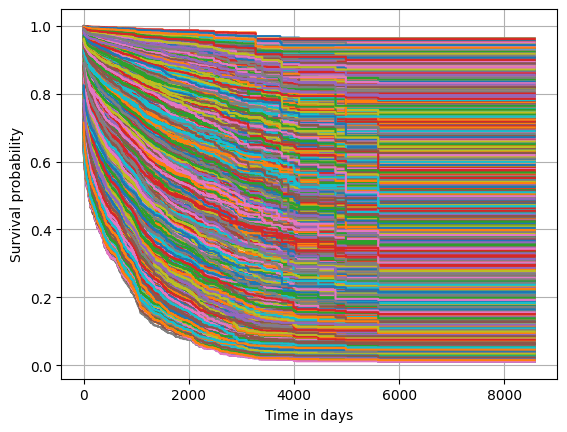

In [20]:
surv = rsf.predict_survival_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post")
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.grid(True)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished


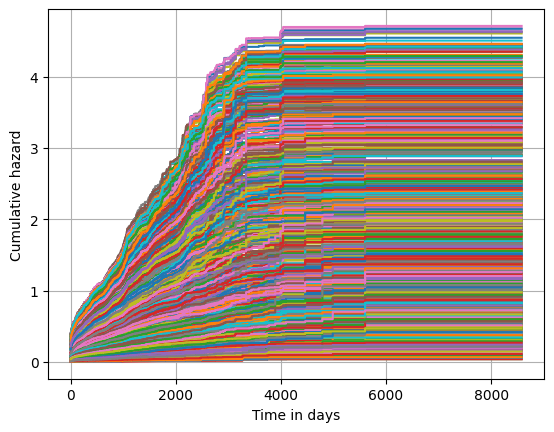

In [21]:
surv = rsf.predict_cumulative_hazard_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post")
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.grid(True)

In [17]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=42)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0

In [18]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
A1c,0.100945,0.004578
FBS,0.073407,0.004986
Total_Cholesterol,0.002812,0.001639
LDL,0.002284,0.001294
TG,0.001090,0.000479
Age_at_Exam,0.000929,0.000449
BMI,0.000611,0.000481
HTN,0.000551,0.000575
sBP,0.000157,0.000191
COPD,0.000110,0.000051


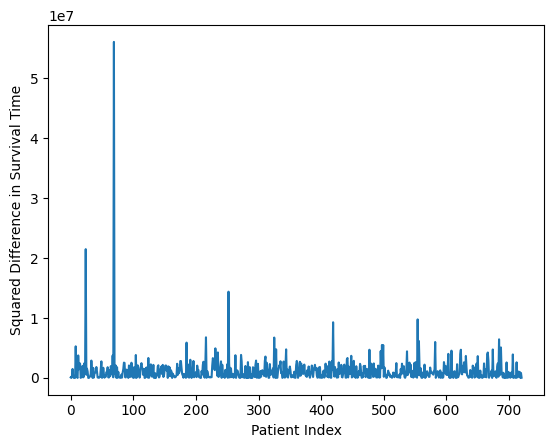

In [43]:
sqdiff = (y_test['DM_survival_int']-pred_test)**2
sbd = list()
for i in range(len(sqdiff)):
    if y_test['Diabetes'][i] == True:
        sbd.append(sqdiff[i])

plt.plot(range(len(sbd)),sbd)
plt.ylabel("Squared Difference in Survival Time")
plt.xlabel("Patient Index")
plt.show()

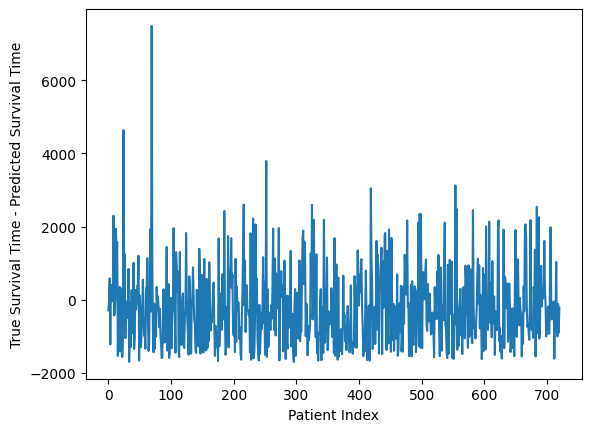

In [44]:
absdiff = y_test['DM_survival_int']-pred_test
abd = list()
for i in range(len(absdiff)):
    if y_test['Diabetes'][i] == True:
        abd.append(absdiff[i])

plt.plot(range(len(abd)),abd)
plt.ylabel("True Survival Time - Predicted Survival Time")
plt.xlabel("Patient Index")
plt.show()

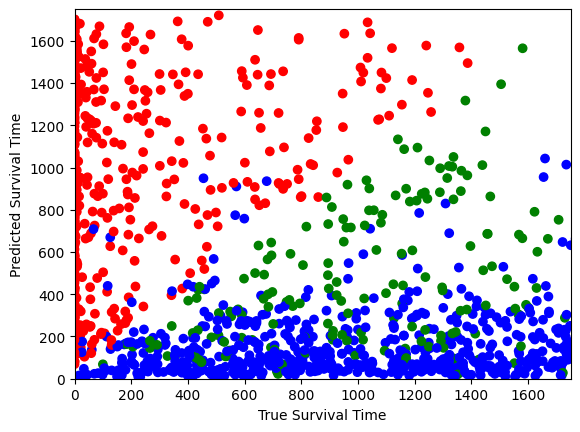

In [63]:
col = np.where(y_test['Diabetes']==0, 'b', np.where(y_test['DM_survival_int'] < pred_test,'r','g'))

plt.scatter(y_test['DM_survival_int'], pred_test, c=col)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
ax = plt.gca()
ax.set_xlim([0, 1750])
ax.set_ylim([0, 1750])
plt.show()

In [33]:
import statistics
print(statistics.mean(absdiff))
print(statistics.median(absdiff))

print(statistics.mean(sqdiff))
print(statistics.median(sqdiff))

1392.654588768782
1207.7051003042066
3804522.174743041
1458551.6093007936
